# New York City High Schools SAT Results (2012)

This data combines multiple datasets from New York City schools to examine differences in SAT scores in 2012 and demographics.  It starts by cleaning, formatting and merging the datasets.  It then attempts to visualize some of the major differences in SAT scores across schools.  The data originally comes from the NYC open data project (https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4).

In [2]:
import pandas
import numpy
import re

#read in the different data files into a panda data frame and place the filenames into a data dictionary
#that points to the data frame datasets
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

#### Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

#### Find correlations between SAT scores and other variables

The analysis below shows that variables such as number taking the test, size of school, average class size, total enrollment, and share of asian students are all highly related to SAT score outcomes.

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

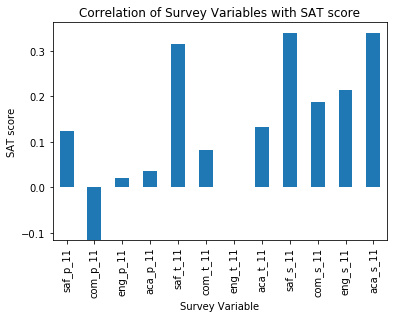

In [11]:
surveyvars = ['saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 
              'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11',
              'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11']

#This code is needed for Jupyter to actually display the graphs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

bargraph = combined.corr()["sat_score"][surveyvars].plot.bar()
bargraph.set_title("Correlation of Survey Variables with SAT score")
bargraph.set_xlabel("Survey Variable")
bargraph.set_ylabel("SAT score")
plt.show()



#### Correlations of survey responses with SAT scores

It appears that student and teacher responses (denoted by "_s_","_t_" variables) are more highly correlated with SAT scores compared to parents responses (denoted by "_p_").  This is consistent with the notion that parents are on average often not heavily engaged in their children's learning particularly once they reach high school.  

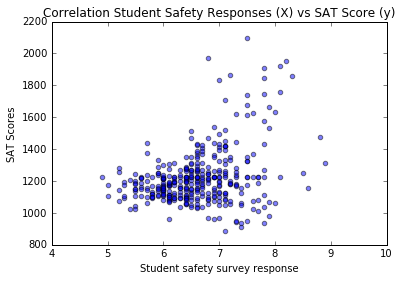

In [60]:
#plt.scatter(combined["saf_s_11"], combined["sat_score"], s=area, c=colors, alpha=0.5)
plt.scatter(combined["saf_s_11"], combined["sat_score"], alpha=0.5)
plt.xlabel("Student safety survey response")
plt.ylabel("SAT Scores")
plt.title("Correlation Student Safety Responses (X) vs SAT Score (y)")

plt.show()

#### Create Graphical Representation of Average SAT Scores By District

This creates a map of scores by district.  Yellow colored dots represent districts with higher scores while darker green colored dots represent districts with lower scores.

In [13]:

#First combine data to the district level
grouped = combined.groupby(["school_dist"])
#now obtain average for each district over the available variables
districts = grouped.agg(np.mean)
districts.reset_index(inplace=True)
avg_safety_score = round(districts["saf_s_11"],2)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
#print(districts["saf_s_11"])
districts["saf_s_11"] = round(districts["saf_s_11"],2)

m.fillcontinents(color='white',lake_color='#85A6D9')
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.title("NYC Average SAT scores by District")
plt.show()


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

#### Safety scores by district in New York City

It appeas that both Bronx and Brooklyn have a few districts with high SAT scores, but also Brooklyn has many districts with low scores as well. A high proportion of solid schools (light green) exists in Manhattan.

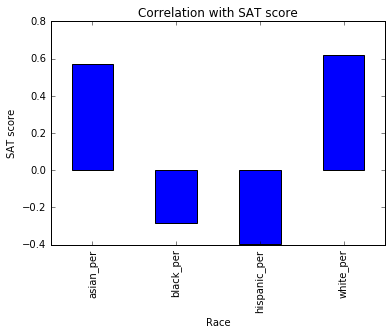

In [80]:
#Investigating racial differences in SAT scores

race = ["asian_per","black_per","hispanic_per","white_per"]
bargraph = correlations[race].plot.bar()
bargraph.set_title("Correlation with SAT score")
bargraph.set_xlabel("Race")
bargraph.set_ylabel("SAT score")
plt.show()

#### Correlations of Race with SAT Scores

The percentage of Asian and White students in a school is positively correlated with higher SAT scores.  In contrast, more black and hispanic students are correlated with lower SAT scores.

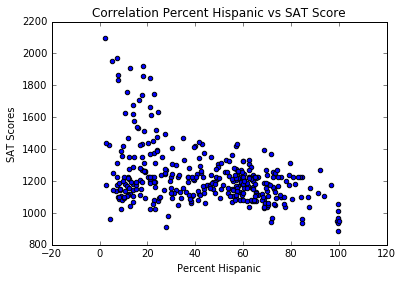

In [83]:
#Exploring schools with low SAT score and high Hispanic Percentage

#make scatter plot
plt.scatter(combined["hispanic_per"], combined["sat_score"])
plt.xlabel("Percent Hispanic")
plt.ylabel("SAT Scores")
plt.title("Correlation Percent Hispanic vs SAT Score")

plt.show()

#### Correlation of Hispanic and SAT Scores

There is a general downward, but noisy trend between higher proportion of Hispanic students and SAT scores.

In [24]:
#Identify schools with more than 95% hispanic_per
#print(combined.head())
schools_95hispanic = combined["SCHOOL NAME"][combined["hispanic_per"]> 95]
print(schools_95hispanic)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### Findings on schools that are mostly Hispanic

These schools are largely international schools and cater to people where english is not the first language.

In [31]:
select = (combined["hispanic_per"]< 10) & (combined["sat_score"] > 1800)
schools_10hispanic = combined["SCHOOL NAME"][select]
print(schools_10hispanic)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### Schools that have a small proportion of hispanics 

These schools with high SAT scores are mainly magnet schools or 
specialized schools

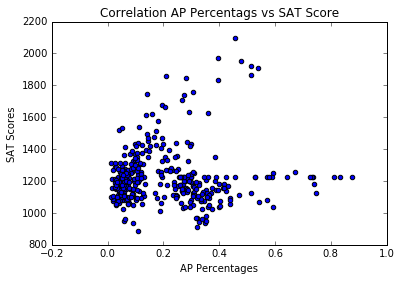

In [86]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
plt.scatter(combined["ap_per"], combined["sat_score"])
plt.xlabel("AP Percentages")
plt.ylabel("SAT Scores")
plt.title("Correlation AP Percentags vs SAT Score")

plt.show()

#### Correlations between AP percentage and SAT score

The correlations are somewhat noisy, but in general with a higher proportion of students taking AP classes there is less variation or higher SAT scores.


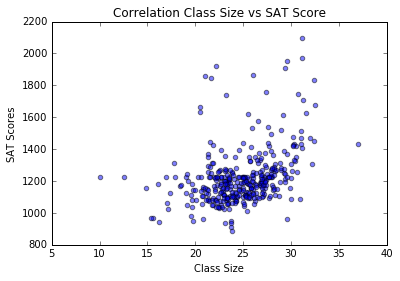

In [87]:
#Correlations between class size and SAT scores
#print(combined.head())
plt.scatter(combined["AVERAGE CLASS SIZE"], combined["sat_score"], alpha=0.5)
plt.xlabel("Class Size")
plt.ylabel("SAT Scores")
plt.title("Correlation Class Size vs SAT Score")
plt.show()

#plot below shows that the correlation is very noisy.  Indeed higher average 
#class sizes does not seem to be strongly (or negatively) related to
#lower average SAT scores

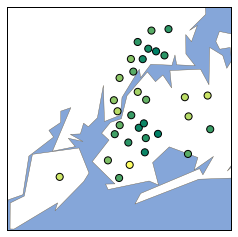

In [89]:
#Identifying best area to live based on school performance

#combine data to district level
grouped = combined.groupby(["school_dist"])
#now obtain average for each district over the available variables
districts = grouped.agg(np.mean)
#print(districts["saf_s_11"])

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
#print(districts["saf_s_11"])
districts["saf_s_11"] = round(districts["saf_s_11"],2)

m.fillcontinents(color='white',lake_color='#85A6D9')
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["sat_score"], cmap="summer")
plt.show()


#### Differences between parent, teacher, and student survey responses

Plots of survey responses for parents, teachers and students shows that there are considerable differences.  In terms of safety parents provide more positive responses compared to teachers and students.  However, while teachers tend to provide more highly positive responses regarding communication students tend to provide more pessimistic responses while parents are in the middle.  Similar results are observed in terms of academic expectations.


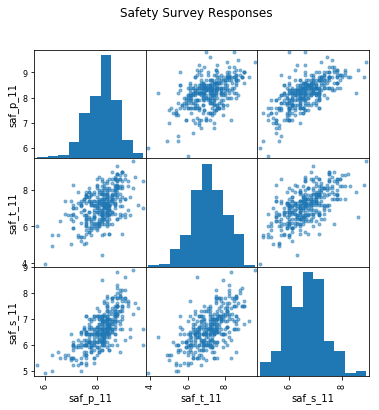

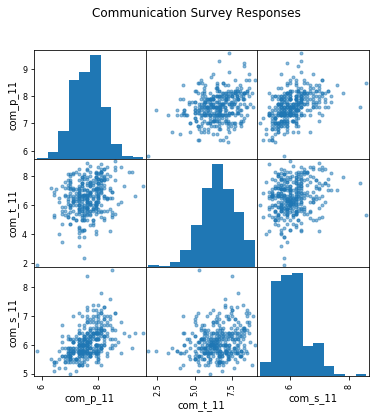

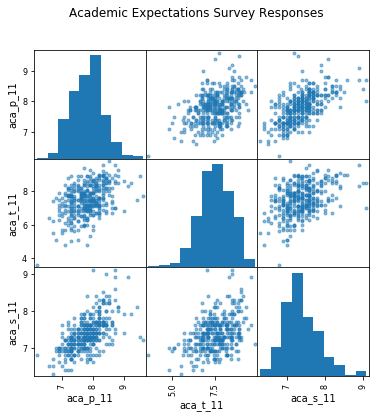

In [32]:
#Differences between parent, teacher and student responses to surveys
import pandas.tools.plotting as plt2
surveyvars = ['saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 
              'saf_t_11', 'com_t_11', 'eng_t_10', 'aca_t_11',
              'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11']

correlations = combined[surveyvars].corr()
#print(correlations)

plt2.scatter_matrix(combined[["saf_p_11","saf_t_11","saf_s_11"]], figsize=[6,6]) #title="Safety"
plt.suptitle('Safety Survey Responses')
plt.show()
plt2.scatter_matrix(combined[["com_p_11","com_t_11","com_s_11"]], figsize=[6,6]) #title="Communication"
plt.suptitle('Communication Survey Responses')
plt.show()
#plt2.scatter_matrix(combined[["eng_p_11","eng_t_10","eng_s_11"]], figsize=[6,6]) #title="Engagement"
#plt.suptitle('Engagement Survey Responses')
#plt.show()
#title="Academic Expectations"
plt2.scatter_matrix(combined[["aca_p_11","aca_t_11","aca_s_11"]], figsize=[6,6])
plt.suptitle('Academic Expectations Survey Responses')
plt.show()


In [47]:
#Assigning a score to schools based on sat_score and other attributes

import statsmodels.api as sm
import numpy as np
combined["intercept"] = 1.0
xcols = ["intercept", "hispanic_per","black_per","asian_per", "AVERAGE CLASS SIZE", "ell_percent", "number_programs"]
logit = sm.OLS(combined["sat_score"],combined[xcols])
result = logit.fit()
print(result.summary())

#Let's create an adjusted score of schools that tries to take into account
#demographic differences and other selection criteria to limit bias 
#created by cherry picking schools or selection of particular students
#into certain location (socio-demographics)




                            OLS Regression Results                            
Dep. Variable:              sat_score   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     129.4
Date:                Mon, 08 May 2017   Prob (F-statistic):           2.78e-86
Time:                        17:13:20   Log-Likelihood:                -2186.0
No. Observations:                 363   AIC:                             4386.
Df Residuals:                     356   BIC:                             4413.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
intercept           1573.1044     62

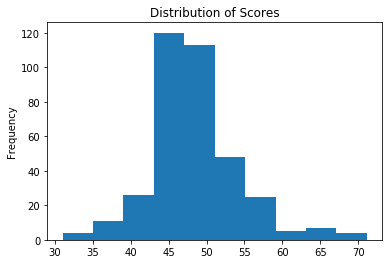

In [46]:
#Controlling above factors we should have scores be equal to deviations from the predicted
ypred = result.predict(combined[xcols])
#lets rebase the differences though so minimum value is zero.  We want scores to range between 0 and 100.
scores=100*(combined["sat_score"]-ypred+min(ypred))/(max(ypred))
scores.plot(kind="hist", bins=10, title="Distribution of Scores")
plt.show()

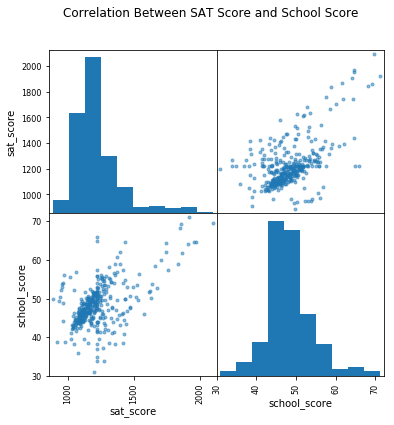

In [48]:
combined["school_score"]=scores
plt2.scatter_matrix(combined[["sat_score","school_score"]], figsize=[6,6])
plt.suptitle('Correlation Between SAT Score and School Score')
plt.show()

# Conclusions

Straight SAT Scores are less than ideal to use as a measure of school performance.  Demographics play a strong role in SAT score outcomes and therefore good scores on quality of school should try to control for some of these difference in socioeconomic characteristics and funding characteristics.  If these school scores do not adjust these differences then schools could start cherry picking students and teachers creating even greater inequality in outcomes. The above graph shows that SAT scores and school scores remain highly correlated.  Nevertheless, the distribution is altered to the right indicating a higher number of schools would be ranked as performing well given the demographic population and schools resources that they have access to.  Nevertheless these scores still remain imperfect and better scores would use historical data to better ensure that scores are not continuously affected year-to-year by changing conditions.